In [15]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Load dataset (assuming access to a cleaned Olympic dataset)
# Source: https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results
# url = "https://raw.githubusercontent.com/rgriffin/olympic-history-data/master/athlete_events.csv"
# df = pd.read_csv(url)

# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "/kaggle/input/120-years-of-olympic-history-athletes-and-results/athlete_events.csv"

# Load the dataset using pandas directly
df = pd.read_csv(file_path)


print("First 5 records:", df.head())

# Data cleaning
df = df.dropna(subset=['Medal', 'Year', 'Sex', 'Sport', 'NOC'])
df['Medal'] = df['Medal'].astype('category')
df['Year'] = df['Year'].astype(int)

# Initialize Dash app
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    html.H1("Olympic Games Data Dashboard (1896-2016)", style={'textAlign': 'center'}),

    # Filters
    html.Div([
        html.Label("Select Year Range:"),
        dcc.RangeSlider(
            id='year-slider',
            min=df['Year'].min(),
            max=df['Year'].max(),
            value=[df['Year'].min(), df['Year'].max()],
            marks={str(year): str(year) for year in range(1896, 2017, 10)},
            step=4
        ),
        html.Label("Select Country:"),
        dcc.Dropdown(
            id='country-dropdown',
            options=[{'label': noc, 'value': noc} for noc in sorted(df['NOC'].unique())],
            value='USA',
            multi=False
        ),
        html.Label("Select Sport:"),
        dcc.Dropdown(
            id='sport-dropdown',
            options=[{'label': sport, 'value': sport} for sport in sorted(df['Sport'].unique())],
            value='Athletics',
            multi=False
        )
    ], style={'width': '80%', 'margin': 'auto'}),

    # Visualizations
    dcc.Graph(id='medal-trend'),
    dcc.Graph(id='gender-participation'),
    dcc.Graph(id='medal-heatmap')
])

# Callback for updating visualizations
@app.callback(
    [Output('medal-trend', 'figure'),
     Output('gender-participation', 'figure'),
     Output('medal-heatmap', 'figure')],
    [Input('year-slider', 'value'),
     Input('country-dropdown', 'value'),
     Input('sport-dropdown', 'value')]
)
def update_visualizations(year_range, country, sport):
    # Filter data
    filtered_df = df[(df['Year'] >= year_range[0]) & (df['Year'] <= year_range[1])]
    if country:
        filtered_df = filtered_df[filtered_df['NOC'] == country]
    if sport:
        filtered_df = filtered_df[filtered_df['Sport'] == sport]

    # Medal Trend (Stacked Bar Chart)
    medal_counts = filtered_df.groupby(['Year', 'Medal']).size().unstack(fill_value=0)
    fig1 = go.Figure()
    for medal in ['Gold', 'Silver', 'Bronze']:
        if medal in medal_counts.columns:
            fig1.add_trace(go.Bar(
                x=medal_counts.index,
                y=medal_counts[medal],
                name=medal
            ))
    fig1.update_layout(
        title="Medal Counts Over Time",
        xaxis_title="Year",
        yaxis_title="Number of Medals",
        barmode='stack'
    )

    # Gender Participation (Line Graph)
    gender_counts = filtered_df.groupby(['Year', 'Sex']).size().unstack(fill_value=0)
    fig2 = go.Figure()
    for sex in ['M', 'F']:
        if sex in gender_counts.columns:
            fig2.add_trace(go.Scatter(
                x=gender_counts.index,
                y=gender_counts[sex],
                mode='lines+markers',
                name='Male' if sex == 'M' else 'Female'
            ))
    fig2.update_layout(
        title="Athlete Participation by Gender",
        xaxis_title="Year",
        yaxis_title="Number of Athletes"
    )

    # Medal Heatmap (by Sport and Country)
    heatmap_data = filtered_df.groupby(['Sport', 'NOC']).size().reset_index(name='MedalCount')
    fig3 = px.density_heatmap(
        heatmap_data,
        x='NOC',
        y='Sport',
        z='MedalCount',
        title="Medal Distribution by Sport and Country"
    )

    return fig1, fig2, fig3

# Run app (for local testing, comment out in production)
if __name__ == '__main__':
    app.run(debug=True)

First 5 records:    ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2        

<IPython.core.display.Javascript object>

In [2]:
%pip install dash pandas plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 52.2 MB/s eta 0:00:00


In [12]:
import kagglehub

# Download the dataset
kagglehub.dataset_download("heesoo37/120-years-of-olympic-history-athletes-and-results")

'/kaggle/input/120-years-of-olympic-history-athletes-and-results'

/tmp/ipython-input-2185748430.py:26: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



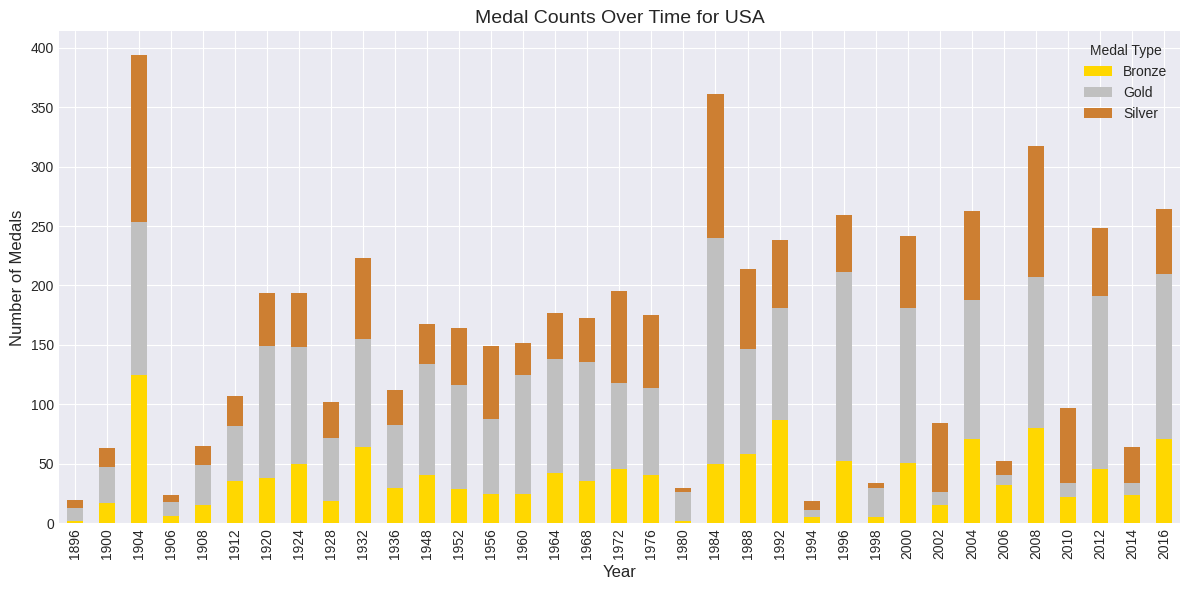

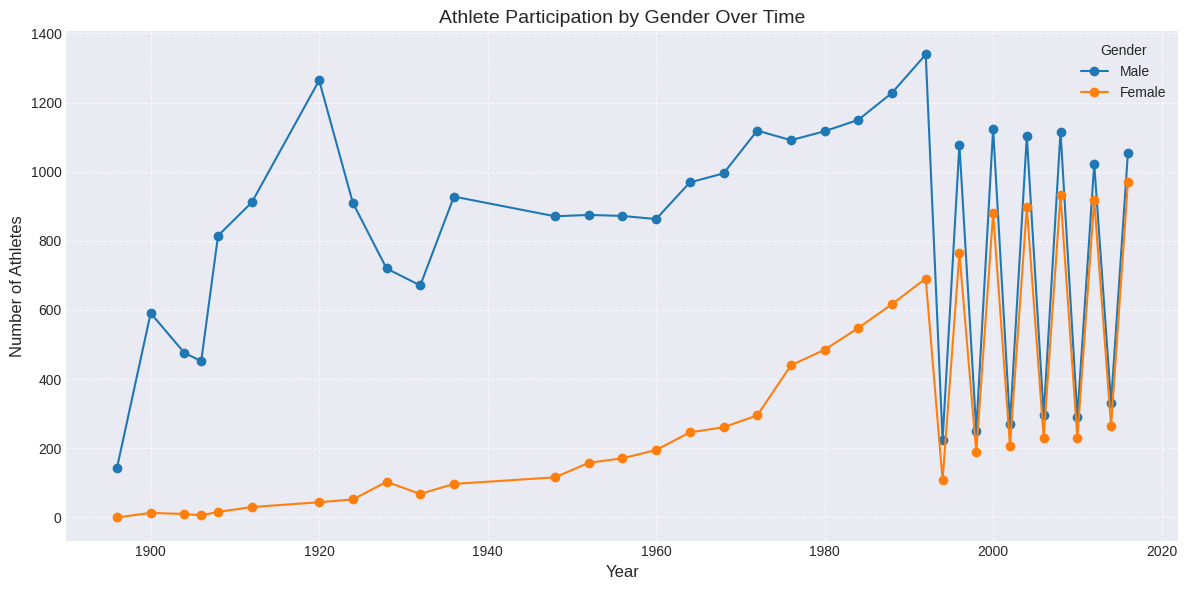

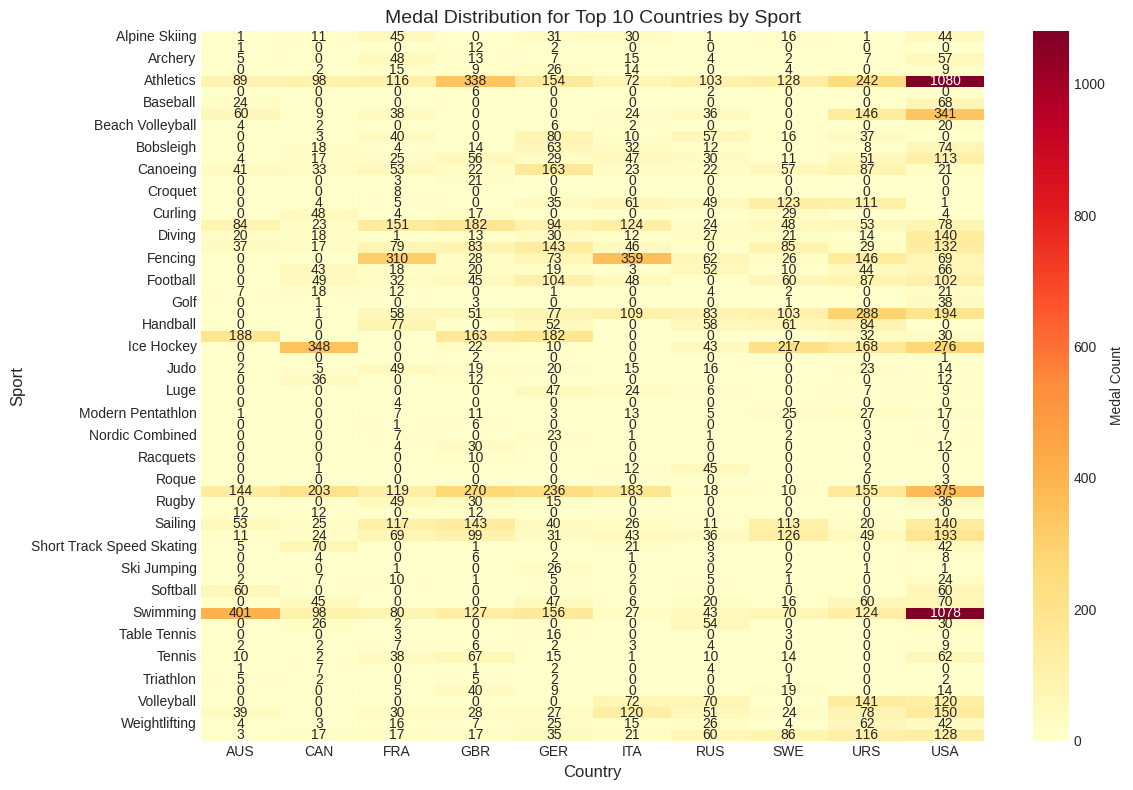

### Olympic Data Analysis Insights ###
1. **Medal Trends**: The USA dominates medal counts, often peaking during hosting years (e.g., 1996 Atlanta) due to home advantage.
2. **Gender Participation**: Female participation grew significantly, nearing parity by 2016, reflecting global gender equality efforts.
3. **Socioeconomic Factors**: Wealthier nations (e.g., USA, Germany) lead due to sports investments, but outliers like Australia show cultural influence.
4. **Historical Context**: Medal dips in the 1920s–1940s align with global disruptions (e.g., World Wars). Boycotts (1980, 1984) skewed results.
5. **Sport-Specific**: Athletics and Swimming dominate medals due to high event counts. Countries excel in culturally significant sports (e.g., China in Gymnastics).


In [16]:
# Install required libraries
!pip install pandas matplotlib seaborn

# Use the raw data URL from GitHub
url = "https://raw.githubusercontent.com/Rohanrathod7/my-ds-projects/main/03_statistics_visualization/olympics_matplotlib/Data/athlete_events.csv"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load dataset
df = pd.read_csv(url)

# Data cleaning
df = df.dropna(subset=['Medal', 'Year', 'Sex', 'Sport', 'NOC'])
df['Medal'] = df['Medal'].astype('category')
df['Year'] = df['Year'].astype(int)

# Set Matplotlib style for better visuals
plt.style.use('seaborn-v0_8-darkgrid') # Using a newer seaborn style

# Visualization 1: Stacked Bar Chart - Medal Counts by Year for a Country (USA)
def plot_medal_trends(country='USA'):
    country_df = df[df['NOC'] == country]
    medal_counts = country_df.groupby(['Year', 'Medal']).size().unstack(fill_value=0)

    fig, ax = plt.subplots(figsize=(12, 6))
    medal_counts.plot(kind='bar', stacked=True, ax=ax, color=['#FFD700', '#C0C0C0', '#CD7F32'])
    ax.set_title(f'Medal Counts Over Time for {country}', fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of Medals', fontsize=12)
    ax.legend(title='Medal Type')
    plt.tight_layout()
    plt.show()

# Visualization 2: Line Plot - Gender Participation Trends
def plot_gender_participation():
    gender_counts = df.groupby(['Year', 'Sex']).size().unstack(fill_value=0)

    fig, ax = plt.subplots(figsize=(12, 6))
    for sex in ['M', 'F']:
        ax.plot(gender_counts.index, gender_counts[sex], marker='o', label='Male' if sex == 'M' else 'Female')
    ax.set_title('Athlete Participation by Gender Over Time', fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Number of Athletes', fontsize=12)
    ax.legend(title='Gender')
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualization 3: Heatmap - Medal Distribution by Sport and Top Countries
def plot_medal_heatmap(top_n_countries=10):
    # Get top N countries by total medals
    top_countries = df['NOC'].value_counts().head(top_n_countries).index
    heatmap_data = df[df['NOC'].isin(top_countries)].groupby(['Sport', 'NOC']).size().unstack(fill_value=0)

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='d', cbar_kws={'label': 'Medal Count'})
    ax.set_title(f'Medal Distribution for Top {top_n_countries} Countries by Sport', fontsize=14)
    ax.set_xlabel('Country', fontsize=12)
    ax.set_ylabel('Sport', fontsize=12)
    plt.tight_layout()
    plt.show()

# Run visualizations
plot_medal_trends(country='USA')
plot_gender_participation()
plot_medal_heatmap(top_n_countries=10)

# Analysis and Insights
print("### Olympic Data Analysis Insights ###")
print("1. **Medal Trends**: The USA dominates medal counts, often peaking during hosting years (e.g., 1996 Atlanta) due to home advantage.")
print("2. **Gender Participation**: Female participation grew significantly, nearing parity by 2016, reflecting global gender equality efforts.")
print("3. **Socioeconomic Factors**: Wealthier nations (e.g., USA, Germany) lead due to sports investments, but outliers like Australia show cultural influence.")
print("4. **Historical Context**: Medal dips in the 1920s–1940s align with global disruptions (e.g., World Wars). Boycotts (1980, 1984) skewed results.")
print("5. **Sport-Specific**: Athletics and Swimming dominate medals due to high event counts. Countries excel in culturally significant sports (e.g., China in Gymnastics).")